In [1]:
# Hide this cell

%matplotlib inline
import matplotlib.pyplot as plt

## Import some things from cstwMPC

# The first step is to be able to bring things in from different directories
import sys 
import os

# Get the path to HARK either from an env variable or use the default. Remove this
# once HARK is pip installable
HARK_PATH = os.path.abspath(os.path.join('..', os.environ.get('HARK_PATH', 'lib/HARK-master')))

sys.path.insert(0, os.path.join(HARK_PATH, 'ConsumptionSaving')) #Path to ConsumptionSaving folder
sys.path.insert(0, HARK_PATH)
sys.path.insert(0, os.path.abspath('../lib'))
from util import log_progress

import numpy as np
from copy import deepcopy

At the onset of the Great Recession, there was a large drop (6.32%, according to FRED) in consumer spending on non-durables.  Some economists have proffered that this could be attributed to precautionary motives-- a perceived increase in household income uncertainty induces more saving (less consumption) to protect future consumption against bad income shocks.  How large of an increase in the standard deviation of (log) permanent income shocks would be necessary to see an 6.32% drop in consumption in one quarter?  What about transitory income shocks?  How high would the perceived unemployment probability have to be?

The first step is to create the ConsumerType we want to solve the model for.

Model set up:
- "Standard" infinite horizon consumption/savings model, with mortality and permanent and temporary shocks to income
- Ex-ante heterogeneity in consumers' discount factors
    
With this basic setup, HARK's IndShockConsumerType is the appropriate ConsumerType.

So we need to prepare the parameters to create that ConsumerType, and then create it.


In [2]:
from HARKutilities import approxUniform

# Bring in what we need from the cstwMPC parameters
init_infinite = {
    "CRRA":1.0,                    # Coefficient of relative risk aversion   
    "Rfree":1.01/(1.0 - 1.0/160.0), # Survival probability,
    "PermGroFac":[1.000**0.25], # Permanent income growth factor (no perm growth),
    "PermGroFacAgg":1.0,
    "BoroCnstArt":0.0,
    "CubicBool":False,
    "vFuncBool":False,
    "PermShkStd":[(0.01*4/11)**0.5],  # Standard deviation of permanent shocks to income
    "PermShkCount":5,  # Number of points in permanent income shock grid
    "TranShkStd":[(0.01*4)**0.5],  # Standard deviation of transitory shocks to income,
    "TranShkCount":5,  # Number of points in transitory income shock grid
    "UnempPrb":0.07,  # Probability of unemployment while working
    "IncUnemp":0.15,  # Unemployment benefit replacement rate
    "UnempPrbRet":None,
    "IncUnempRet":None,
    "aXtraMin":0.00001,  # Minimum end-of-period assets in grid
    "aXtraMax":20,  # Maximum end-of-period assets in grid
    "aXtraCount":20,  # Number of points in assets grid,
    "aXtraExtra":[None],
    "aXtraNestFac":3,  # Number of times to 'exponentially nest' when constructing assets grid
    "LivPrb":[1.0 - 1.0/160.0],  # Survival probability
    "DiscFac":0.97,             # Default intertemporal discount factor, # dummy value, will be overwritten
    "cycles":0,
    "T_cycle":1,
    "T_retire":0,
    'T_sim':1200,  # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
    'T_age': 400,
    'IndL': 10.0/9.0,  # Labor supply per individual (constant),
    'aNrmInitMean':np.log(0.00001),
    'aNrmInitStd':0.0,
    'pLvlInitMean':0.0,
    'pLvlInitStd':0.0,
    'AgentCount':0,  # will be overwritten by parameter distributor
}

# Import the HARK ConsumerType we want 
# Here, we bring in an agent making a consumption/savings decision every period, subject
# to transitory and permanent income shocks.
from ConsIndShockModel import IndShockConsumerType

# Now initialize a baseline consumer type, using default parameters from infinite horizon cstwMPC
BaselineType = IndShockConsumerType(**init_infinite)
BaselineType.AgentCount = 10000 # Assign the baseline consumer type to have many agents in simulation

Now, add in ex-ante heterogeneity in consumers' discount factors

The cstwMPC parameters do not define a discount factor, since there is ex-ante heterogeneity in the discount factor.  To prepare to create this ex-ante heterogeneity, first create the desired number of consumer types

In [3]:
num_consumer_types   = 7 # declare the number of types we want
ConsumerTypes = [] # initialize an empty list

for nn in log_progress(range(num_consumer_types), every=1):
    # Now create the types, and append them to the list ConsumerTypes
    newType = deepcopy(BaselineType)    
    ConsumerTypes.append(newType)
    ConsumerTypes[-1].seed = nn # give each consumer type a different RNG seed



Now, generate the desired ex-ante heterogeneity, by giving the different consumer types each their own discount factor

In [4]:
# First, decide the discount factors to assign
bottomDiscFac  = 0.9800
topDiscFac     = 0.9934 
DiscFac_list   = approxUniform(N=num_consumer_types,bot=bottomDiscFac,top=topDiscFac)[1]

# Now, assign the discount factors we want
for j in log_progress(range(num_consumer_types), every=1):
    ConsumerTypes[j].DiscFac = DiscFac_list[j]

Now, solve and simulate the model for each consumer type:

In [5]:
for ConsumerType in log_progress(ConsumerTypes, every=1):
    ### First solve the problem for this ConsumerType.
    ConsumerType.solve()
    
    ### Now simulate many periods to get to the stationary distribution
    ConsumerType.T_sim = 1000
    ConsumerType.initializeSim()
    ConsumerType.simulate()


Now, create functions to see how aggregate consumption changes after household income uncertainty increases in various ways:

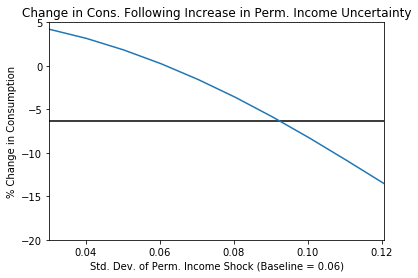

In [6]:
# In order to see how consumption changes, we need to be able to calculate average consumption
# in the last period.  Create a function do to that here.
def calcAvgC(ConsumerTypes):
    """
    This function calculates average consumption in the economy in last simulated period,
    averaging across ConsumerTypes.
    """
    # Make arrays with all types' (normalized) consumption and permanent income level
    cNrm = np.concatenate([ThisType.cNrmNow for ThisType in ConsumerTypes])
    pLvl = np.concatenate([ThisType.pLvlNow for ThisType in ConsumerTypes])
    
    # Calculate and return average consumption level in the economy
    avgC = np.mean(cNrm*pLvl) 
    return avgC
        
# Now create a function to run the experiment we want -- change income uncertainty, and see
# how consumption changes
def cChangeAfterUncertaintyChange(ConsumerTypes,newVals,paramToChange):
    """
    Function to calculate the change in average consumption after change(s) in income uncertainty
    Inputs:
        * consumerTypes, a list of consumer types
        * newvals, a list of new values to use for the income parameters
        * paramToChange, a string telling the function which part of the income process to change
    """

    # Initialize an empty list to hold the changes in consumption that happen after parameters change.
    changesInConsumption = []
    
    # Get average consumption before parameters change
    oldAvgC = calcAvgC(ConsumerTypes)

    # Now loop through the new income parameter values to assign, first assigning them, and then
    # solving and simulating another period with those values
    for newVal in log_progress(newVals, every=1):
        if paramToChange in ["PermShkStd","TranShkStd"]: # These parameters are time-varying, and thus are contained in a list.
            thisVal = [newVal] # We need to make sure that our updated values are *also* in a (one element) list.
        else:
            thisVal = newVal

        # Copy everything we have from the consumerTypes 
        ConsumerTypesNew = deepcopy(ConsumerTypes)
          
        for index,ConsumerTypeNew in enumerate(ConsumerTypesNew):
            setattr(ConsumerTypeNew,paramToChange,thisVal) # Set the changed value of the parameter        

            # Because we changed the income process, and the income process is created
            # during initialization, we need to be sure to update the income process
            ConsumerTypeNew.updateIncomeProcess()

            # Solve the new problem
            ConsumerTypeNew.solve()
            
            # Initialize the new consumer type to have the same distribution of assets and permanent
            # income as the stationary distribution we simulated above
            ConsumerTypeNew.initializeSim() # Reset the tracked history
            ConsumerTypeNew.aNrmNow = ConsumerTypes[index].aNrmNow # Set assets to stationary distribution
            ConsumerTypeNew.pLvlNow = ConsumerTypes[index].pLvlNow # Set permanent income to stationary dstn
            
            # Simulate one more period, which changes the values in cNrm and pLvl for each agent type
            ConsumerTypeNew.simOnePeriod()

        # Calculate the percent change in consumption, for this value newVal for the given parameter
        newAvgC = calcAvgC(ConsumerTypesNew)
        changeInConsumption = 100. * (newAvgC - oldAvgC) / oldAvgC

        # Append the change in consumption to the list changesInConsumption
        changesInConsumption.append(changeInConsumption)

    # Return the list of changes in consumption
    return changesInConsumption

## Define functions that calculate the change in average consumption after income process changes
def cChangeAfterPrmShkChange(newVals):
    return cChangeAfterUncertaintyChange(ConsumerTypes,newVals,"PermShkStd")

def cChangeAfterTranShkChange(newVals):
    return cChangeAfterUncertaintyChange(ConsumerTypes,newVals,"TranShkStd")

def cChangeAfterUnempPrbChange(newVals):
    return cChangeAfterUncertaintyChange(ConsumerTypes,newVals,"UnempPrb")

## Now, plot the functions we want

# Import a useful plotting function from HARKutilities
from HARKutilities import plotFuncs

ratio_min = 0.5 # minimum number to multiply income parameter by
targetChangeInC = -6.32 # Source: FRED
num_points = 10 #number of parameter values to plot in graphs

## First change the variance of the permanent income shock
perm_ratio_max = 2 # Put whatever value in you want!  maximum number to multiply std of perm income shock by

perm_min = BaselineType.PermShkStd[0] * ratio_min
perm_max = BaselineType.PermShkStd[0] * perm_ratio_max

plt.ylabel('% Change in Consumption')
plt.xlabel('Std. Dev. of Perm. Income Shock (Baseline = ' + str(round(BaselineType.PermShkStd[0],2)) + ')')
plt.title('Change in Cons. Following Increase in Perm. Income Uncertainty')
plt.ylim(-20.,5.)
plt.hlines(targetChangeInC,perm_min,perm_max)
plotFuncs([cChangeAfterPrmShkChange],perm_min,perm_max,N=num_points)